In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
import fix_yahoo_finance as fix

In [3]:
data = fix.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "MSFT",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "10y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True
    )
data.to_csv("stock_data.csv")

[*********************100%***********************]  1 of 1 downloaded


In [4]:
df = pd.read_csv("stock_data.csv")

In [5]:
print(df.head())

         Date   Open   High    Low  Close    Volume
0  2009-05-05  15.76  15.84  15.37  15.48  66835500
1  2009-05-06  15.70  15.70  15.34  15.48  59639100
2  2009-05-07  15.62  15.64  14.98  15.12  68727200
3  2009-05-08  15.23  15.37  14.98  15.20  67597600
4  2009-05-11  15.02  15.44  14.87  15.12  63762600


In [6]:
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
Date     2517 non-null object
Close    2517 non-null float64
dtypes: float64(1), object(1)
memory usage: 39.4+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df = df.set_index(['Date'], drop=True)

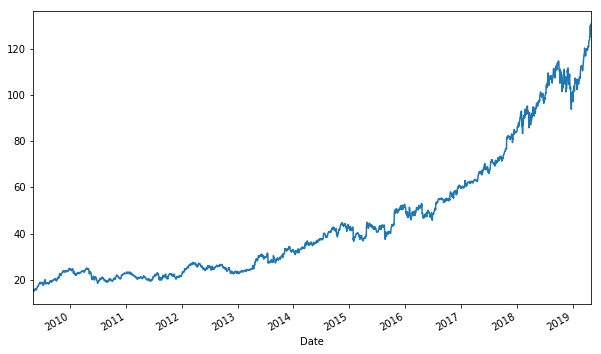

In [10]:
# df = df.sort_index()
plt.figure(figsize=(10, 6))
df['Close'].plot();

In [11]:
split_date = pd.Timestamp('2018-10-01')

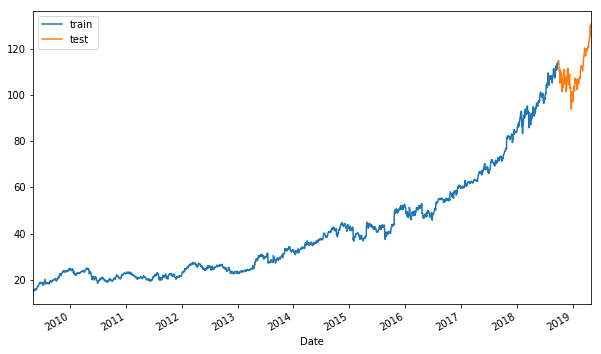

In [12]:
df =  df['Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [13]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1, 1))
test_sc = scaler.transform(test.values.reshape(-1, 1))

In [14]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [15]:
df.head()

Date
2009-05-05    15.48
2009-05-06    15.48
2009-05-07    15.12
2009-05-08    15.20
2009-05-11    15.12
Name: Close, dtype: float64

## ANN

In [16]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
2369/2369 [==============================] - 1s 594us/step - loss: 0.0098
Epoch 2/100
2369/2369 [==============================] - 1s 294us/step - loss: 0.0033
Epoch 3/100
2369/2369 [==============================] - 1s 296us/step - loss: 0.0083
Epoch 4/100
2369/2369 [==============================] - 1s 296us/step - loss: 0.0020
Epoch 5/100
2369/2369 [==============================] - 1s 289us/step - loss: 0.0012
Epoch 6/100
2369/2369 [==============================] - 1s 222us/step - loss: 0.0012
Epoch 7/100
2369/2369 [==============================] - 1s 295us/step - loss: 0.0014
Epoch 8/100
2369/2369 [==============================] - 1s 227us/step - loss: 0.0015
Epoch 00008: early stopping


In [17]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.950
The R2 score on the Test set is:	0.649


## LSTM

In [18]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

In [19]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (2369, 1, 1)
Test shape:  (147, 1, 1)


In [20]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=10, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2369/2369 [==============================] - 5s 2ms/step - loss: 0.5764
Epoch 2/100
2369/2369 [==============================] - 2s 753us/step - loss: 0.3042
Epoch 3/100
2369/2369 [==============================] - 2s 758us/step - loss: 0.1342
Epoch 4/100
2369/2369 [==============================] - 2s 747us/step - loss: 0.0603
Epoch 5/100
2369/2369 [==============================] - 2s 753us/step - loss: 0.0302
Epoch 6/100
2369/2369 [==============================] - 2s 789us/step - loss: 0.0144
Epoch 7/100
2369/2369 [==============================] - 2s 926us/step - loss: 0.0066
Epoch 8/100
2369/2369 [==============================] - 2s 826us/step - loss: 0.0036
Epoch 9/100
2369/2369 [==============================] - 2s 756us/step - loss: 0.0025
Epoch 10/100
2369/2369 [==============================] - 2s 756us/step - loss: 0.0021
Epoch 11/100
2369/2369 [==============================] - 2s 752us/step - loss: 0.0018
Epoch 12/100
2369/2369 [==============================

In [21]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.996
The R2 score on the Test set is:	0.860


In [22]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

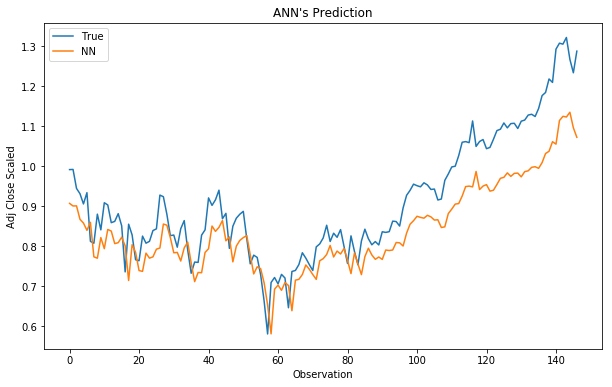

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

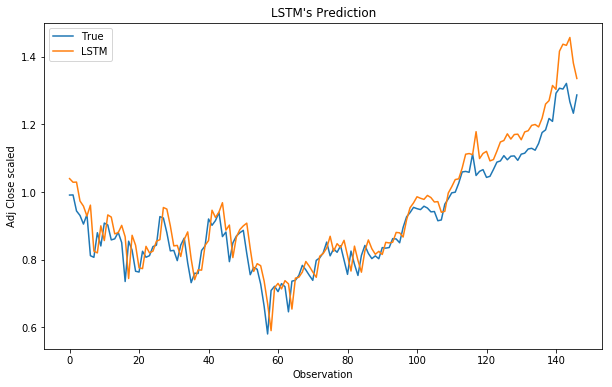

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();

In [25]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print ('Test Data Summary')
print('NN   --> MSE: %f'%nn_test_mse, "------- R2 score:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))
print('LSTM --> MSE: %f'%lstm_test_mse, "------- R2 score:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

147/147 [==============================] - 1s 5ms/step
Test Data Summary
NN   --> MSE: 0.008130 ------- R2 score:	0.649
LSTM --> MSE: 0.003246 ------- R2 score:	0.860


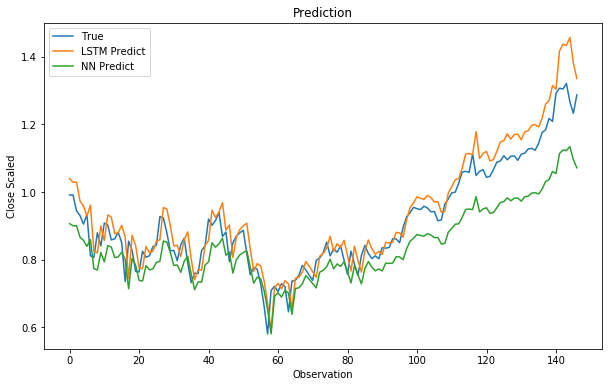

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(lstm_y_pred_test, label='LSTM Predict')
plt.plot(nn_y_pred_test, label='NN Predict')
plt.title("Prediction")
plt.xlabel('Observation')
plt.ylabel('Close Scaled')
plt.legend()
plt.show();